## Jordi Blasco Lozano 
## 14. Grafos en la vida real

### 14.1 Node2Vec

Node2Vec es un algoritmo de representación de un grafo en un espacio de dimensión reducida. La idea es que nodos que están cerca en el grafo original, estén cerca en el espacio de dimensión reducida. Para ello, se utiliza un algoritmo de random walk sesgado que permite recorrer el grafo y obtener las representaciones de los nodos en el espacio de dimensión reducida.

### 14.1.1. Incrustaciones y word2vec 

- Las incrustaciones de los nodos en un gráfico son las representaciones de baja dimensión de los nodos en el gráfico. 
- Las incrustaciones de los nodos se pueden utilizar para realizar diversas tareas en el gráfico, como clasificación, agrupación y predicción de enlaces. 
- El algoritmo Node2Vec se basa en el algoritmo Word2Vec. Word2Vec es un algoritmo de aprendizaje de representación que se utiliza para aprender las incrustaciones de palabras en un texto.

### 14.1.2. Algoritmo Node2Vec
Para representar los nodos de un grafo en un espacio de baja dimensión Node2Vec utiliza dos pasos:

1. Generar random walks en el grafo para obtener secuencias de nodos.
2. Aprender las incrustaciones de los nodos utilizando las secuencias de nodos generadas en el paso 1.


### 14.1.2.1. Fragmento de código
Primero importamos las librerías necesarias y generamos el grafo que usaremos posteriormente. Lo imprimiremos para ver cómo es el grafo generado.


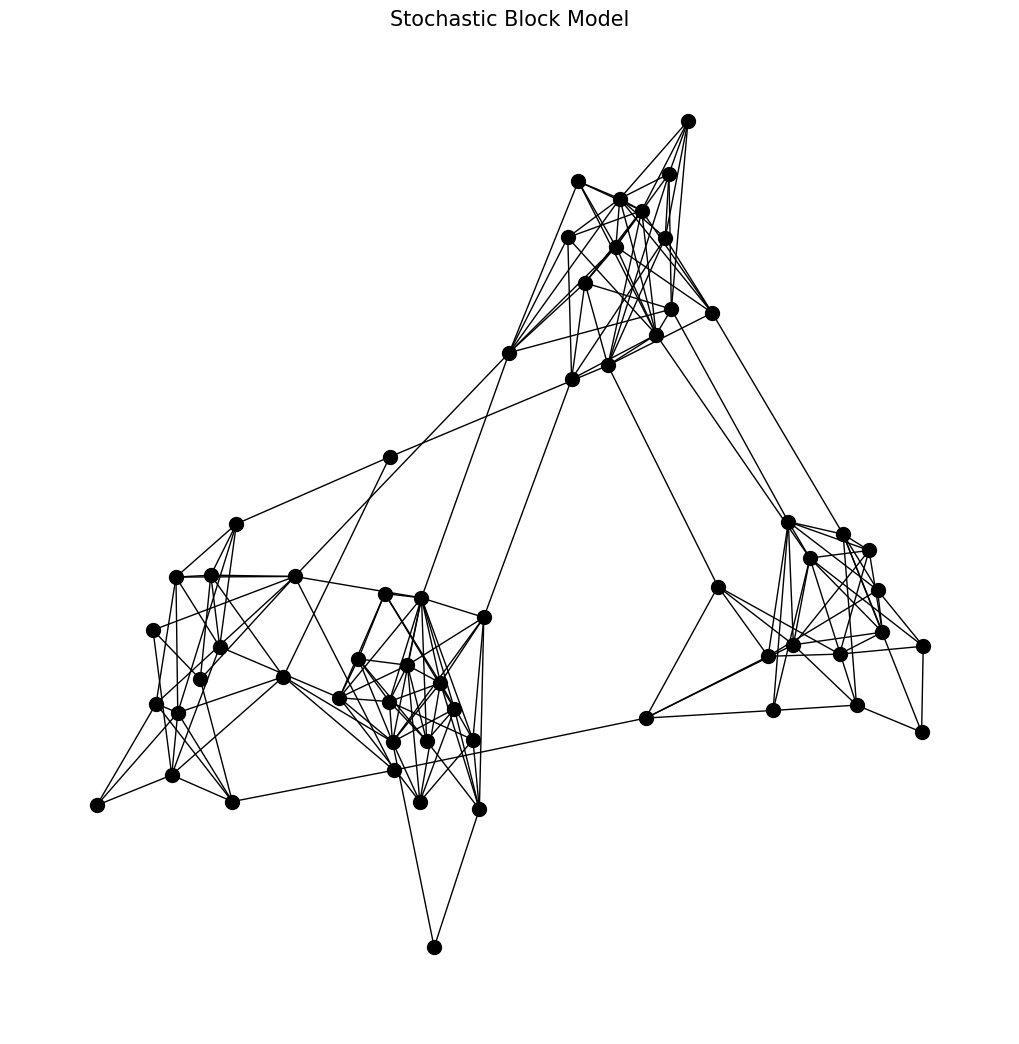

In [6]:
import numpy as np
import networkx as nx
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

G = nx.stochastic_block_model([15, 15, 15, 15], [ 
                                            [0.4, 0.01, 0.01, 0.01],
                                            [0.01, 0.4, 0.01, 0.01],
                                            [0.01, 0.01, 0.4, 0.01],
                                            [0.01, 0.01, 0.01, 0.4]
                                        ], seed=1)



plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=100, node_color='black', font_weight='bold', font_size=10)
plt.title("Stochastic Block Model", fontsize=15)
plt.show()

# imprimimos el grafo generado

Definiremos las funciones necesarias para realizar el algoritmo Node2Vec.


In [7]:

# Función para generar un random walk desde un nodo
def node2vec_random_walk(G, nodo_inicio, walk_length):
    walk = [nodo_inicio] # Se inicializa la caminata con el nodo de inicio
    while len(walk) < walk_length: # El bucle se repite hasta que la caminata alcance walk_length o hasta que el nodo actual no tenga vecinos
        nodo_actual = walk[-1] # Se obtiene el nodo actual
        vecinos = list(G.neighbors(nodo_actual)) # Se obtienen los vecinos del nodo actual
        if len(vecinos) > 0: 
            walk.append(np.random.choice(vecinos))  # Selecciona un vecino al azar
        else:
            break
    return walk # Se devuelve la caminata por la que ha pasado el random walk

# Función para generar múltiples random walks desde cada nodo del grafo
def generate_node2vec_walks(G, num_walks, walk_length):
    walks = [] # Inicializamos una lista para almacenar todos los random walks
    nodos = list(G.nodes()) # Obtenemos todos los nodos del grafo
    for _ in range(num_walks): # Repetiremos los random walks num_walks tantas veces como 
        np.random.shuffle(nodos)  # Mezcla los nodos para añadir aleatoriedad
        for node in nodos:
            walks.append(node2vec_random_walk(G, node, walk_length))  # Genera una caminata aleatoria desde el nodo y la añade a la lista
    return walks

# Función principal de Node2Vec
def node2vec(G, dimensions, num_walks, walk_length):
    walks = generate_node2vec_walks(G, num_walks, walk_length)  # Genera todas las caminatas aleatorias y las almacena en la lista
    walks = [list(map(str, walk)) for walk in walks]  # Convierte los nodos a cadenas para gensim

    model = Word2Vec(walks, vector_size=dimensions, window=5, workers=3)  # Se entrena el modelo Word2Vec con las caminatas aleatorias generadas con Node2Vec y los parametros de vector_size: el tamaño de los vectores de incrustación, window: la ventana de contexto y workers: el número de hilos de CPU para usar
    return model

### 14.1.3 Node2Vec en acción
Probaremos el algoritmo Node2Vec con un grafo generado anteriormente. Entrenaremos el modelo y obtendremos los embeddings de los nodos que luego imprimiremos. Lo que hará el algoritmo es asignar a cada nodo un vector de 16 dimensiones que representa la posición del nodo en un espacio de baja dimensión.


In [8]:

model = node2vec(G, dimensions=16, num_walks=10, walk_length=80)  # Entrena el modelo Node2Vec

# Obtiene el embedding de un nodo específico (por ejemplo, nodo 0)
node_id = 2 # Seleccionamos un nodo de ejemplo
embedding = model.wv[str(node_id)] # con model.wv[str(node_id)] obtenemos el embedding del nodo, es decir, el vector de 16 dimensiones que representa el nodo en el espacio de baja dimensión
print(f"Embedding del nodo {node_id}: {embedding}") 

# Obtiene los embeddings de todos los nodos
embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
print(f"Estructura de los embeddings: {embeddings.shape}") # Imprime la forma de los embeddings


Embedding del nodo 2: [ 0.10351776 -0.29959965  1.5914881   0.77954197  0.21898608 -0.17447431
  1.2860304  -0.00860269  2.1155684  -0.2457374  -0.00559701  0.7753162
  0.451324   -0.07495168  1.0102135   1.8231183 ]
Estructura de los embeddings: (60, 16)


### 14.1.4 Visualización de los embeddings
Una vez que hemos obtenido los embeddings de los nodos, podemos visualizarlos en un espacio de baja dimensión. Para ello, utilizaremos principal component analysis (PCA) para reducir la dimensión de los embeddings a 2 y poder visualizarlos en un gráfico.

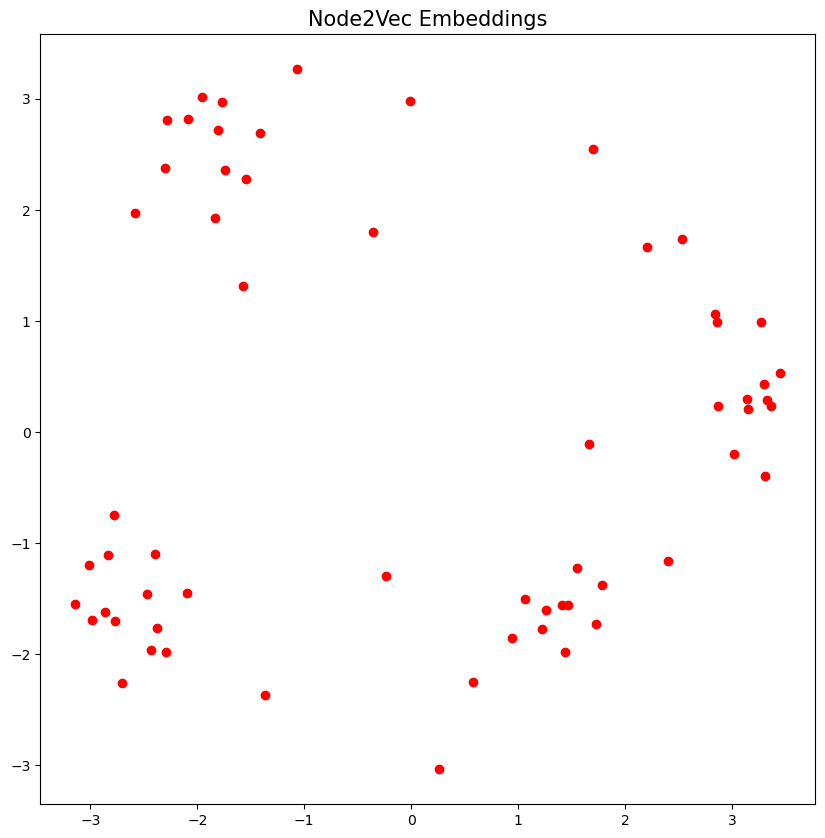

In [9]:

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Usaremos un plt.scatter para visualizar los embeddings en un gráfico 2D
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='r')
plt.title("Node2Vec Embeddings", fontsize=15)
plt.show()

### 14.1.5 Conclusiones
Tal como hemos visto en este ejemplo, Node2Vec es un algoritmo muy útil para representar nodos de un grafo en un espacio de baja dimensión. Al ver la visualización final de los embeddings, podemos observar que los nodos que están cerca en el grafo original (con agrupaciones de 15 nodos en 4 comunidades) 


## 14.2.2 Ejercicio 2 
Usaremos los 5 grafos de la practica pasada para aplicar el algoritmo Node2Vec y obtener los embeddings de los nodos. Luego visualizaremos los embeddings en un espacio de baja dimensión.


In [10]:
G1 = nx.erdos_renyi_graph(10, 0.4, seed=1) 

G2 = nx.barabasi_albert_graph(10, 2, seed=1)

G3 = nx.watts_strogatz_graph(10, 2, 0.2, seed=1)

G4 = nx.random_tree(10, seed=1)

G5 = nx.stochastic_block_model([5, 5], [[1, 0.2], [0.2, 1]], seed=3)

Grafo 1


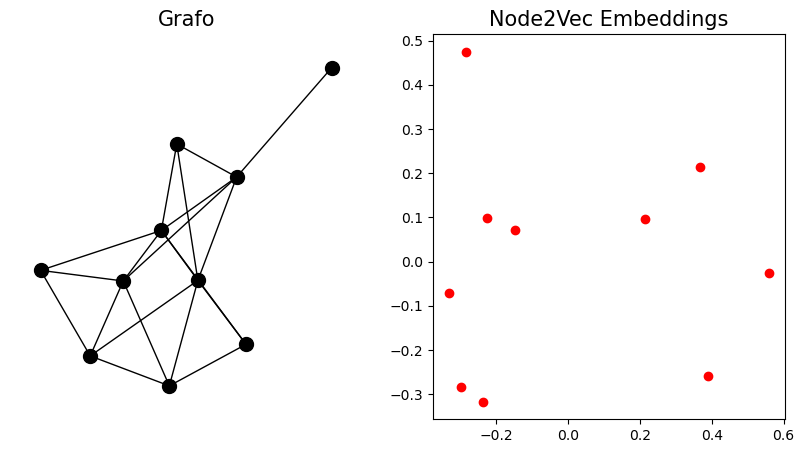

Grafo 2


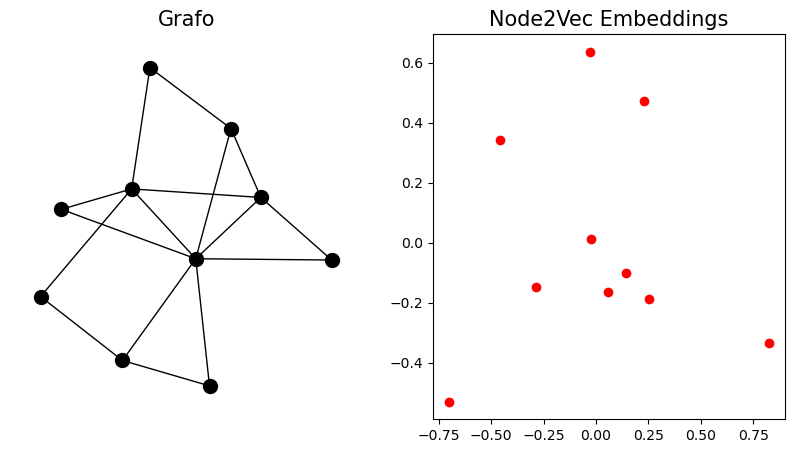

Grafo 3


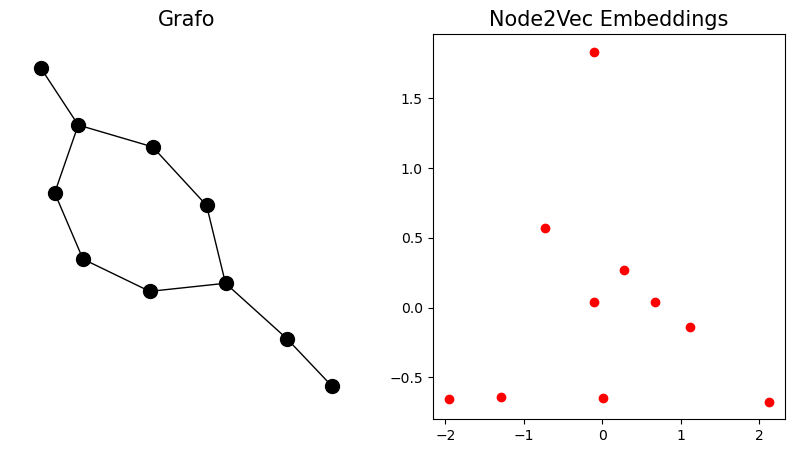

Grafo 4


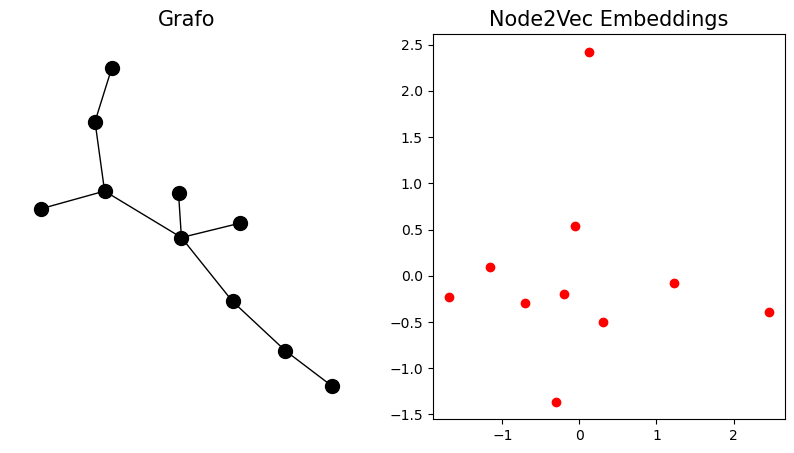

Grafo 5


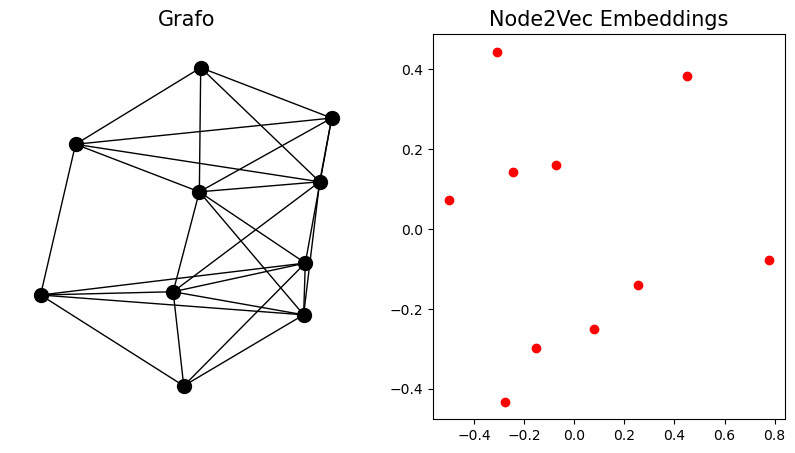

In [16]:
# Entrenamiento del modelo Node2Vec para cada grafo, guardaremos el grafo, el modelo y los embeddings en una tupla para manejar posteriormente de forma más sencilla la impresion de los grafos y embeddings

G1_model1_embeddings1 = (G1, np.array([node2vec(G1, dimensions=20, num_walks=50, walk_length=80).wv[str(node)] for node in G1.nodes()]))
G2_model2_embeddings2 = (G2, np.array([node2vec(G2, dimensions=20, num_walks=50, walk_length=80).wv[str(node)] for node in G2.nodes()]))
G3_model3_embeddings3 = (G3, np.array([node2vec(G3, dimensions=20, num_walks=50, walk_length=80).wv[str(node)] for node in G3.nodes()]))
G4_model4_embeddings4 = (G4, np.array([node2vec(G4, dimensions=20, num_walks=50, walk_length=80).wv[str(node)] for node in G4.nodes()]))
G5_model5_embeddings5 = (G5, np.array([node2vec(G5, dimensions=20, num_walks=50, walk_length=80).wv[str(node)] for node in G5.nodes()]))



# He creado una función para imprimir el grafo y los embeddings en un solo gráfico para poder compararlos visualmente y no tener que escribirlos 5 veces, lo que hace el codigo es calcular los embeddings y visualizarlos en un gráfico junto con el grafo original.
def impresion(G, embeddings):
    
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # juntaremos la visualización del grafo y de los embeddings en un solo gráfico
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(G, seed=1)
    nx.draw(G, pos, node_size=100, node_color='black', font_weight='bold', font_size=10)
    plt.title(f"Grafo", fontsize=15)
    
    plt.subplot(1, 2, 2)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='r')
    plt.title("Node2Vec Embeddings", fontsize=15)
    plt.show()
    
# Por cada grafo, imprimimos el grafo y los embeddings 

for i, (G, embeddings) in enumerate([G1_model1_embeddings1, G2_model2_embeddings2, G3_model3_embeddings3, G4_model4_embeddings4, G5_model5_embeddings5]):
    print(f"Grafo {i+1}")
    impresion(G, embeddings)
    

### 14.2.3 Conclusiones 
Podemos observar que los embeddings de los nodos de los grafos correspondientes se agrupan de manera similar a los grafos originales. No se puede observar tan claramente como en el ejemplo anterior, pero se puede apreciar que los nodos que están cerca en el grafo original también están cerca en el espacio de baja dimensión. La calidad de los embeddings depende de muchos factores, tal como vemos en este ejemplo donde los grafos son pequeños y no se pueden apreciar tan claramente las agrupaciones. Para mejorar la calidad de los embeddings, se pueden ajustar los parámetros del algoritmo Node2Vec, como el tamaño de los vectores de incrustación, la ventana de contexto y el número de caminatas aleatorias.